In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("HomeC2.csv")
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
df.head(2)

,House overall,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,...,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,month,day,weekday,hour,minute
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 14:00:00,0.932833,0.000033,0.442633,0.12415,0.006983,0.013083,0.03135,0.001017,0.004067,0.001517,...,0.75,282.0,0.0,24.4,0.0,1,1,Friday,14,0
2016-01-01 14:01:00,0.934333,0.000000,0.444067,0.12400,0.006983,0.013117,0.03150,0.001017,0.004067,0.001650,...,0.75,282.0,0.0,24.4,0.0,1,1,Friday,14,1


In [3]:
data = df[['Living room', 'temperature', 'humidity',
       'visibility', 'apparentTemperature', 'pressure', 'windSpeed',
       'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint',
       'precipProbability']]

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
data[data.columns[1:]] = scaler.fit_transform(data[data.columns[1:]])
scaler_target = MinMaxScaler(feature_range=(0, 1))
data[['Living room']] = scaler_target.fit_transform(data[['Living room']])

In [5]:
size = int(len(df.loc[:'2016-11-1 00:00']))
data_train = data[:size]
data_test = data[size:]
X_train, X_test = [], []
Y_train, Y_test = [], []
n_past=1
n_future=1
for i in range(n_past, len(data_train)-n_future+1):
    X_train.append(data_train.iloc[i-n_past:i, 0:data.shape[1]])
    Y_train.append(data_train.iloc[i+n_future-1:i+n_future, 0])
for i in range(n_past, len(data_test)-n_future+1):
    X_test.append(data_test.iloc[i-n_past:i, 0:data_test.shape[1]])
    Y_test.append(data_test.iloc[i+n_future-1:i+n_future, 0])
    
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)
print('Y_train shape', Y_train.shape)
print('Y_test shape', Y_test.shape)

X_train shape (438360, 1, 12)
X_test shape (65548, 1, 12)
Y_train shape (438360, 1)
Y_test shape (65548, 1)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import Bidirectional

In [7]:
model = Sequential()
model.add(LSTM(25, activation='relu', return_sequences = False, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))
model.add(Dense(Y_train.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25)                3800      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 3,826
Trainable params: 3,826
Non-trainable params: 0
_________________________________________________________________


2022-12-20 02:01:13.433431: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 02:01:13.874210: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22254 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


2022-12-20 02:01:15.482115: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Train MSE minimum: 0.000931045797187835


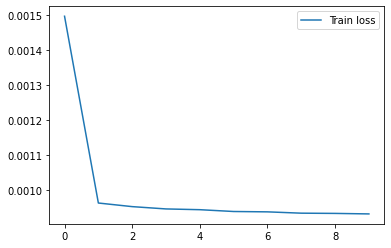

In [8]:
model_fit = model.fit(X_train, Y_train, epochs=10, verbose=0)
Train_pred = model.predict(X_train, verbose=0)
Y_pred = model.predict(X_test, verbose=0)
plt.plot(model_fit.history['loss'], label='Train loss')
plt.legend()
print('Train MSE minimum:', min(model_fit.history['loss']))

0.006114068437381605

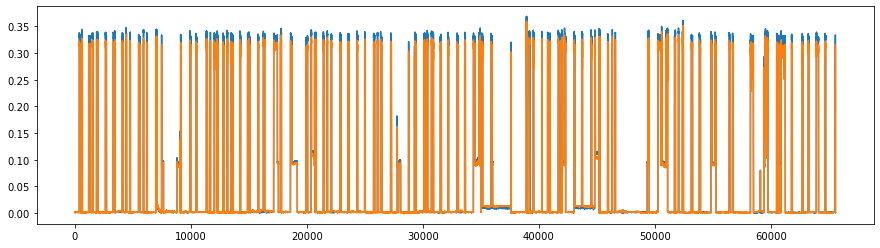

In [9]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
data[['Living room']] = scaler_target.inverse_transform(data[['Living room']])
Y_pred = scaler_target.inverse_transform(Y_pred)
Train_pred = scaler_target.inverse_transform(Train_pred)
plt.figure(figsize=(15,4))
plt.plot(data[['Living room']][size:-1].values)
plt.plot(Y_pred)
np.sqrt(mean_squared_error(Y_pred[:,0].tolist(), data[['Living room']][size:-1].values))

MSE: 0.00004
RMSE: 0.00611
MAE: 0.003
MAPE: inf
R^2 score: 0.997


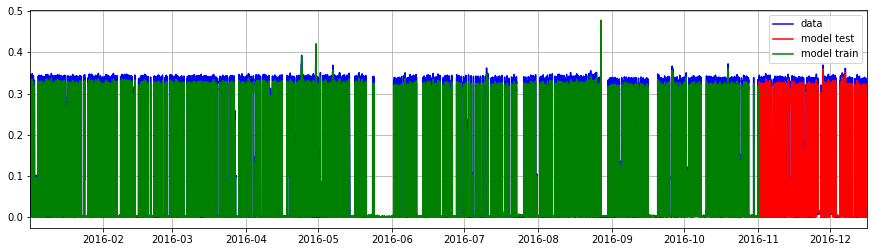

In [10]:
Y_pred_series = pd.Series(Y_pred.flatten().tolist(), index=data['Living room'][size:-n_past].index)
Train_pred_series = pd.Series(Train_pred.flatten().tolist(), index=data['Living room'][n_past:size].index)
plt.figure(figsize=(15,4))
plt.plot(data['Living room'][:-n_past], c='blue', label='data')
plt.plot(Y_pred_series, c='red', label='model test')
plt.plot(Train_pred_series, c='green', label='model train')
plt.legend()
plt.grid(), plt.margins(x=0);
Y_test = data['Living room'][size:-n_past]

# calcolo errore
print('MSE: %.5f' % (mean_squared_error(Y_pred, Y_test)))
print('RMSE: %.5f' % np.sqrt(mean_squared_error(Y_pred, Y_test)))
MAE = mean_absolute_error(Y_test, Y_pred)
MAPE = np.mean(np.abs(Y_pred[:,0] - Y_test.values)/np.abs(Y_test.values))
print('MAE: %.3f' % MAE)
print('MAPE: %.3f' %MAPE)
print('R^2 score: %.3f' % r2_score(Y_test, Y_pred))

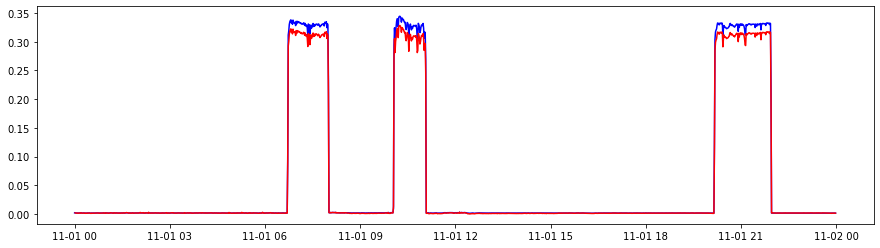

In [11]:
d1 = plt.figure(figsize=(15,4))
plt.plot(data['Living room']['2016-11-1'], c='blue', label='data')
plt.plot(Y_pred_series['2016-11-1'], c='red', label='model test')

In [12]:
df_r = data['Living room']['2016-11']
df_r = pd.DataFrame({"Living room_r":df_r})
df_p = Y_pred_series['2016-11']
df_p = pd.DataFrame({"Living room_p":df_p})
df_t = pd.merge(df_r, df_p, how='inner', on='time')
df_t.to_csv('Device8.csv', index=False)